# Simulated Annealing for TSP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.stats import sem, t
import pandas as pd
import seaborn as sns

In [2]:
def get_city_coord_dict(filename):
    '''Opens the file with cities and corresponding coordinates. Puts it in an ordered dictionary.
    Input: file name with path.
    Ouput: Ordered dictionary of cities with corresponding x and y coordinates in a numpy array.'''
    city_coord_dict = {}

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line[0].isdigit():
                split = line.split()

                city_coord_dict[int(split[0])] = np.array([float(coord) for coord in line.split()[-2:]])

    return OrderedDict(city_coord_dict)

#Open initial file, store cities with coordinates

# filename = "TSP-Configurations/eil51.tsp.txt"
filename = "TSP-Configurations/a280.tsp.txt"
# filename = "TSP-Configurations/pcb442.tsp.txt"
init_cities = get_city_coord_dict(filename)

def get_distance(city_a, city_b):
    '''Calculates distance between city a and city b.
    Input: numpy arrays of city_a and city_b coordinates.
    Output: Euclidean distance between the two cities (as a scalar)'''
    return np.linalg.norm(city_a - city_b)

def total_distance(cities):
    '''Calculates the total distance of the route of visiting all cities in order specified.
    Input: OrderedDict of cities (keys) with their coordinates (np.arrays of x and y)
    Output: Total route distance (scalar)'''

    city_coords = list(cities.values())

    #Init variable: link last city with first
    total_distance = get_distance(city_coords[-1], city_coords[0])
    
    #Connect every subsequent pair of cities
    for i in range(len(cities) -1):
        total_distance += get_distance(city_coords[i], city_coords[i+1])

    return total_distance

def visualize_routes(cities):
    '''Visualize the cities on a plane and the routes between cities.
    Input: OrderedDict of cities (keys) and coordinates(values).
    Output: plot of cities and routes between them.
    '''
    city_coords = list(cities.values())
    for city in city_coords:
        plt.scatter(city[0], city[1])

    #Add connecting lines 
    for i in range(len(city_coords) - 1):
        plt.plot([city_coords[i][0], city_coords[i+1][0]], [city_coords[i][1], city_coords[i+1][1]])

    #Connect last city to first
    plt.plot([city_coords[-1][0], city_coords[0][0]], [city_coords[-1][1], city_coords[0][1]])
    plt.show()


In [3]:
class SimulatedAnnealing:
    def __init__(self, cities, C, T0, max_step=100, init_seed=1):
        self.cities_old = cities
        self.C = C
        self.T0 = T0
        self.step = 0
        self.max_step = max_step
        self.seed = init_seed

    def nearest_neighbor_heuristic(self):
        cities = list(self.cities_old.keys())
        current_city = np.random.choice(cities)
        solution = [current_city]

        while len(solution) < len(cities):
            distances = [(city, np.linalg.norm(np.array(self.cities_old[current_city]) - np.array(self.cities_old[city])))
                         for city in cities if city not in solution]
            next_city, _ = min(distances, key=lambda x: x[1])
            solution.append(next_city)
            current_city = next_city

        return OrderedDict((city, self.cities_old[city]) for city in solution)

    def proposal(self, cities):
        # Select a random key from the dictionary
        random_key = np.random.choice(list(cities.keys()))
        value = cities[random_key]

        proposal_cities = cities.copy()
        del proposal_cities[random_key]

        # Move it to here
        new_index = np.random.randint(0, len(cities) - 1)

        # Create a new dictionary with the rearranged order
        proposal_cities = OrderedDict(list(cities.items())[:new_index] + [(random_key, value)] + list(
            cities.items())[new_index:])
        return proposal_cities

    def two_opt(self, cities):
        i, j = np.random.choice(len(cities), size=2, replace=False)

        if i > j:
            i, j = j, i

        new_order = list(cities.items())[:i + 1] + list(reversed(list(cities.items())[i + 1:j + 1])) + list(
            cities.items())[j + 1:]
        return OrderedDict(new_order)

    def evaluate(self, cities, proposal_cities, T):
        dist_proposal_cities = total_distance(proposal_cities)
        dist_cities = total_distance(cities)
        alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)

        #(possibly) update best overall
        if dist_proposal_cities < dist_cities:
            self.best_overall = proposal_cities

        return alpha_func
    

    def select(self, alpha_func, proposal_cities):
        u = np.random.uniform()
        if u <= alpha_func:
            #accept
            cities_new = proposal_cities
        else:
            #reject
            cities_new = self.cities_old

        return cities_new

    def exponential_cooling(self, step):
        return self.T0 * np.exp(-self.C * step)

    def linear_cooling(self, step):
        return self.T0 / (1 + self.C * step)

    def run(self, cooling_scheme, swap_scheme):
        self.cities_old = self.nearest_neighbor_heuristic()  # Initialize with nearest neighbor heuristic

        while self.step < self.max_step:
            self.seed += 1
            # The temperature scheme (the cooling scheme)
            if cooling_scheme == 'logarithmic':
                T = (self.C * np.log(self.step + self.T0)) ** (-1)
            elif cooling_scheme == 'exponential':
                T = self.exponential_cooling(self.step)
            elif cooling_scheme == 'linear':
                T = self.linear_cooling(self.step)
            else:
                raise ValueError("Invalid cooling_scheme. Choose from 'logarithmic', 'exponential', or 'linear'.")

            self.step = self.step + 1
            # 1. Proposal
            if swap_scheme == '2-opt':
                proposal_cities = self.two_opt(self.cities_old)
            elif swap_scheme == 'Single Node Swap':
                proposal_cities = self.proposal(self.cities_old)
            else:
                raise ValueError("Invalid swap_scheme. Choose from '2-opt' or 'Single Node Swap'.")

            # 2. Evaluate
            alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
            # 3. Select
            cities_new = self.select(alpha_func, proposal_cities)
            self.cities_old = cities_new

        return cities_new

In [4]:
def calculate_confidence_interval(data, confidence=0.95):

    n = len(data)
    m = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return m - h, m + h


/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_75698/3720091390.py:53: RuntimeWarning: overflow encountered in exp
  alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_75698/3720091390.py:53: RuntimeWarning: overflow encountered in scalar divide
  alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_75698/3720091390.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)
/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_75698/3720091390.py:53: RuntimeWarning: invalid value encountered in scalar divide
  alpha_func =  min(np.exp(-(dist_proposal_cities - dist_cities)/T), 1)


KeyboardInterrupt: 

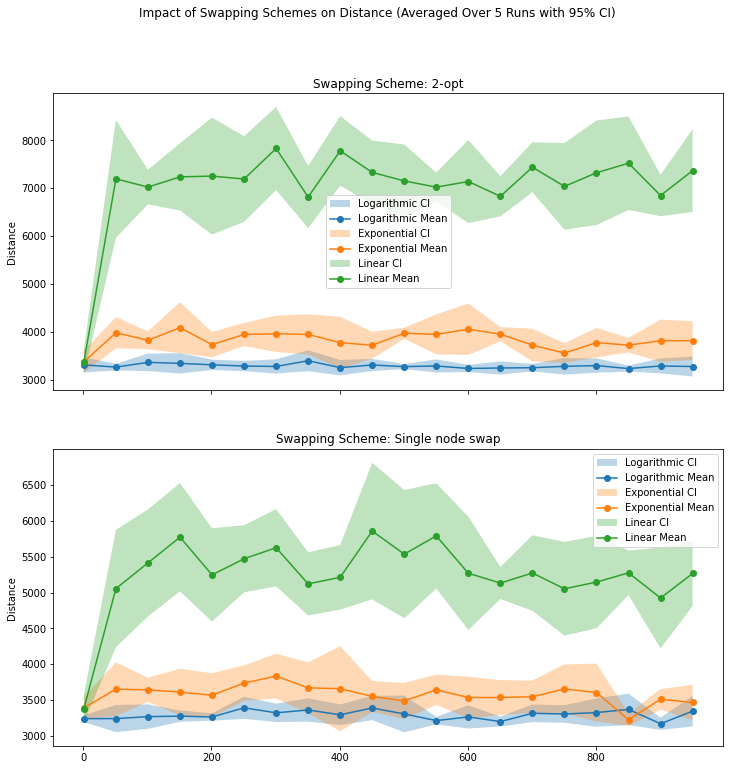

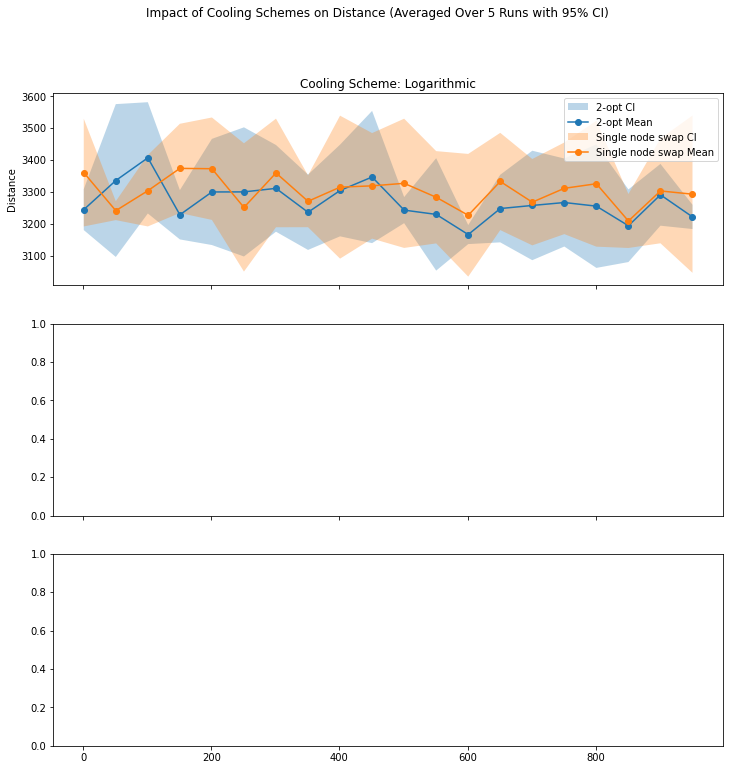

In [10]:
def run_experiment(cooling_scheme, swap_scheme, max_iterations_range, num_runs=5):
    results = {'Iteration': [], 'Distance': []}

    for max_iter in max_iterations_range:
        distances = []

        for _ in range(num_runs):
            sa_instance = SimulatedAnnealing(init_cities, C= 0.9855031390846619, T0=4371.8793675683855, max_step=max_iter, init_seed=np.random.randint(1, 1000))
            final_cities = sa_instance.run(cooling_scheme, swap_scheme)

            distances.append(total_distance(final_cities))

        mean_distance = np.mean(distances)
        lower_bound, upper_bound = calculate_confidence_interval(distances)

        results['Iteration'].append(max_iter)
        results['Distance'].append((mean_distance, lower_bound, upper_bound))

    return pd.DataFrame(results)

# Run experiment for each swapping scheme
cooling_schemes = ['logarithmic', 'exponential', 'linear']
swap_schemes = ['2-opt', 'Single Node Swap']
max_iterations_range = np.arange(1, 1001, 50)  # Adjust the range as needed

# Create subplots for each swapping scheme
fig, axs = plt.subplots(len(swap_schemes), 1, figsize=(12, 12), sharex=True)
fig.suptitle('Impact of Swapping Schemes on Distance (Averaged Over 5 Runs with 95% CI)')

for i, swap_scheme in enumerate(swap_schemes):
    for j, cooling_scheme in enumerate(cooling_schemes):
        df_results = run_experiment(cooling_scheme, swap_scheme, max_iterations_range)
        axs[i].fill_between(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[1]), df_results['Distance'].apply(lambda x: x[2]), alpha=0.3, label=f'{cooling_scheme.capitalize()} CI')
        axs[i].plot(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[0]), label=f'{cooling_scheme.capitalize()} Mean', marker='o')

    axs[i].set_title(f'Swapping Scheme: {swap_scheme.capitalize()}')
    axs[i].set_ylabel('Distance')
    axs[i].legend()

    # Save the plot as a PNG file
plt.savefig(f'swap_scheme_{swap_scheme}.png')  

# Create subplots for each cooling scheme
fig, axs_cooling = plt.subplots(len(cooling_schemes), 1, figsize=(12, 12), sharex=True)
fig.suptitle('Impact of Cooling Schemes on Distance (Averaged Over 5 Runs with 95% CI)')

for i, cooling_scheme in enumerate(cooling_schemes):
    for swap_scheme in swap_schemes:
        df_results = run_experiment(cooling_scheme, swap_scheme, max_iterations_range)
        axs_cooling[i].fill_between(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[1]), df_results['Distance'].apply(lambda x: x[2]), alpha=0.3, label=f'{swap_scheme.capitalize()} CI')
        axs_cooling[i].plot(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[0]), label=f'{swap_scheme.capitalize()} Mean', marker='o')

    axs_cooling[i].set_title(f'Cooling Scheme: {cooling_scheme.capitalize()}')
    axs_cooling[i].set_ylabel('Distance')
    axs_cooling[i].legend()

    # Save the plot as a PNG file
plt.savefig(f'cooling_scheme_{cooling_scheme}.png')  

plt.xlabel('Max Iterations')
plt.show()

KeyboardInterrupt: 

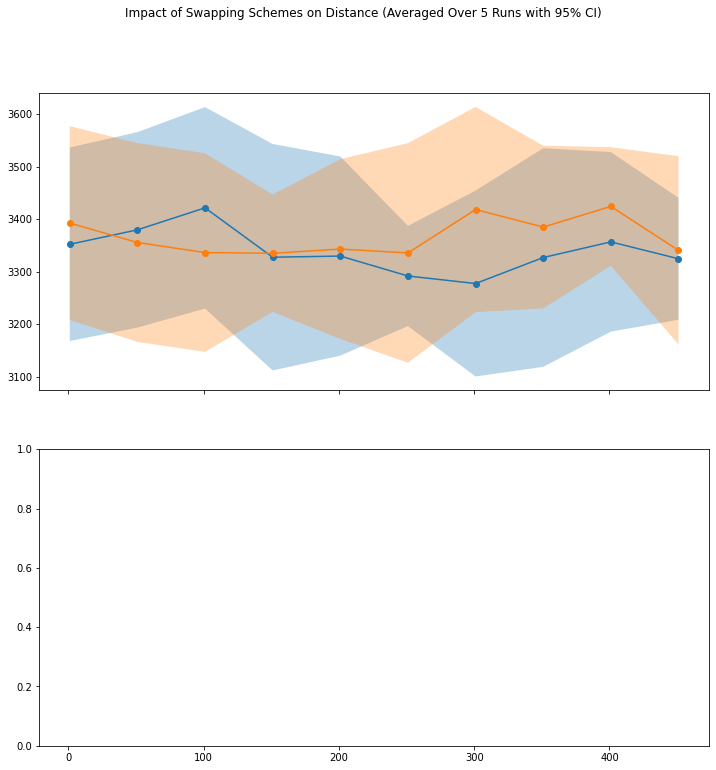

In [12]:
# List of seed values
seed_values = [69, 308, 542, 330, 135]

# Function to run an experiment for a specific seed
def run_experiment_for_seed(cooling_scheme, swap_scheme, max_iterations_range, seed, num_runs=5):
    results = {'Iteration': [], 'Distance': []}

    for max_iter in max_iterations_range:
        distances = []

        for _ in range(num_runs):
            sa_instance = SimulatedAnnealing(init_cities, C=0.9855031390846619, T0=4371.8793675683855, max_step=max_iter, init_seed=seed)
            final_cities = sa_instance.run(cooling_scheme, swap_scheme)

            distances.append(total_distance(final_cities))

        mean_distance = np.mean(distances)
        lower_bound, upper_bound = calculate_confidence_interval(distances)

        results['Iteration'].append(max_iter)
        results['Distance'].append((mean_distance, lower_bound, upper_bound))

    return pd.DataFrame(results)

# Run experiment for each swapping scheme
cooling_schemes = ['logarithmic', 'exponential', 'linear']
swap_schemes = ['2-opt', 'Single Node Swap']
max_iterations_range = np.arange(1, 501, 50)  # Adjust the range as needed


# Create subplots for each swapping scheme
fig, axs = plt.subplots(len(swap_schemes), 1, figsize=(12, 12), sharex=True)
fig.suptitle('Impact of Swapping Schemes on Distance (Averaged Over 5 Runs with 95% CI)')

for i, swap_scheme in enumerate(swap_schemes):
    for j, cooling_scheme in enumerate(cooling_schemes):
        for seed in seed_values:
            df_results = run_experiment_for_seed(cooling_scheme, swap_scheme, max_iterations_range, seed)
            axs[i].fill_between(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[1]), df_results['Distance'].apply(lambda x: x[2]), alpha=0.3, label=f'Seed {seed} {cooling_scheme.capitalize()} CI')
            axs[i].plot(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[0]), label=f'Seed {seed} {cooling_scheme.capitalize()} Mean', marker='o')

    axs[i].set_title(f'Swapping Scheme: {swap_scheme.capitalize()}')
    axs[i].set_ylabel('Distance')
    axs[i].legend()

    # Save the plot as a PNG file
    plt.savefig(f'swap_scheme_{swap_scheme}.png')  

# Create subplots for each cooling scheme
fig, axs_cooling = plt.subplots(len(cooling_schemes), 1, figsize=(12, 12), sharex=True)
fig.suptitle('Impact of Cooling Schemes on Distance (Averaged Over 5 Runs with 95% CI)')

for i, cooling_scheme in enumerate(cooling_schemes):
    for swap_scheme in swap_schemes:
        for seed in seed_values:
            df_results = run_experiment_for_seed(cooling_scheme, swap_scheme, max_iterations_range, seed)
            axs_cooling[i].fill_between(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[1]), df_results['Distance'].apply(lambda x: x[2]), alpha=0.3, label=f'Seed {seed} {swap_scheme.capitalize()} CI')
            axs_cooling[i].plot(df_results['Iteration'], df_results['Distance'].apply(lambda x: x[0]), label=f'Seed {seed} {swap_scheme.capitalize()} Mean', marker='o')

    axs_cooling[i].set_title(f'Cooling Scheme: {cooling_scheme.capitalize()}')
    axs_cooling[i].set_ylabel('Distance')
    axs_cooling[i].legend()

    # Save the plot as a PNG file
    plt.savefig(f'cooling_scheme_{cooling_scheme}.png')  

plt.xlabel('Max Iterations')
plt.show()